In [1]:
library(tokenizers)
library(stringr)
library(neuralnet)
library(testthat)
options(warn=-1)

## The Word2Vec Assignment

In the assignment for the semantic models chapter, we are going to apply word2vec to a somewhat larger corpus of text drawn from the children's book "Green eggs and ham" by Dr. Zeus. Again we use a children's book, because the text is repetitive and so the model has common contexts to work with but doesn't take too long to train.

Note I have removed quotation marks because they break the rules of field names in R and I have changed question marks to the token QUESTION, for the same reason.

In [2]:
text = "DO WOULD YOU LIKE GREEN EGGS AND HAM QUESTION

I DO NOT LIKE THEM SAM I AM .
I DO NOT LIKE GREEN EGGS AND HAM .

WOULD YOU LIKE THEM HERE OR THERE QUESTION

I WOULD NOT LIKE THEM HERE OR THERE .
I WOULD NOT LIKE THEM ANYWHERE .
I DO NOT LIKE GREEN EGGS AND HAM .
I DO NOT LIKE THEM SAM I AM .

WOULD YOU LIKE THEM IN A HOUSE QUESTION
WOULD YOU LIKE THEN WITH A MOUSE QUESTION

I DO NOT LIKE THEM IN A HOUSE .
I DO NOT LIKE THEM WITH A MOUSE .
I DO NOT LIKE THEM HERE OR THERE .
I DO NOT LIKE THEM ANYWHERE .
I DO NOT LIKE GREEN EGGS AND HAM .
I DO NOT LIKE THEM SAM I AM .

WOULD YOU EAT THEM IN A BOX QUESTION
WOULD YOU EAT THEM WITH A FOX QUESTION

NOT IN A BOX . NOT WITH A FOX .
NOT IN A HOUSE . NOT WITH A MOUSE .
I WOULD NOT EAT THEM HERE OR THERE .
I WOULD NOT EAT THEM ANYWHERE .
I WOULD NOT EAT GREEN EGGS AND HAM .
I DO NOT LIKE THEM SAM I AM .

WOULD YOU QUESTION COULD YOU QUESTION IN A CAR QUESTION
EAT THEM EAT THEM HERE THEY ARE .

I WOULD NOT COULD NOT IN A CAR .

YOU MAY LIKE THEM . YOU WILL SEE .
YOU MAY LIKE THEM IN A TREE

I WOULD NOT COULD NOT IN A TREE .
NOT IN A CAR YOU LET ME BE .
I DO NOT LIKE THEM IN A BOX .
I DO NOT LIKE THEM WITH A FOX .
I DO NOT LIKE THEM IN A HOUSE .
I DO NOT LIKE THEM WITH A MOUSE .
I DO NOT LIKE THEM HERE OR THERE .
I DO NOT LIKE THEM ANYWHERE .
I DO NOT LIKE GREEN EGGS AND HAM .
I DO NOT LIKE THEM SAM I AM ."

corpus = tokenize_ptb(tolower(text))
corpus
T = length(corpus[[1]])
print(paste0("corpus size = ", T))
for (i in 1:T){
    if (corpus[[1]][i] == "1"){
        print (i)
    }
}

[[1]]
  [1] "do"       "would"    "you"      "like"     "green"    "eggs"    
  [7] "and"      "ham"      "question" "i"        "do"       "not"     
 [13] "like"     "them"     "sam"      "i"        "am"       "."       
 [19] "i"        "do"       "not"      "like"     "green"    "eggs"    
 [25] "and"      "ham"      "."        "would"    "you"      "like"    
 [31] "them"     "here"     "or"       "there"    "question" "i"       
 [37] "would"    "not"      "like"     "them"     "here"     "or"      
 [43] "there"    "."        "i"        "would"    "not"      "like"    
 [49] "them"     "anywhere" "."        "i"        "do"       "not"     
 [55] "like"     "green"    "eggs"     "and"      "ham"      "."       
 [61] "i"        "do"       "not"      "like"     "them"     "sam"     
 [67] "i"        "am"       "."        "would"    "you"      "like"    
 [73] "them"     "in"       "a"        "house"    "question" "would"   
 [79] "you"      "like"     "then"     "with"     "a"        "mouse"   
 [85] "question" "i"        "do"       "not"      "like"     "them"    
 [91] "in"       "a"        "house"    "."        "i"        "do"      
 [97] "not"      "like"     "them"     "with"     "a"        "mouse"   
[103] "."        "i"        "do"       "not"      "like"     "them"    
[109] "here"     "or"       "there"    "."        "i"        "do"      
[115] "not"      "like"     "them"     "anywhere" "."        "i"       
[121] "do"       "not"      "like"     "green"    "eggs"     "and"     
[127] "ham"      "."        "i"        "do"       "not"      "like"    
[133] "them"     "sam"      "i"        "am"       "."        "would"   
[139] "you"      "eat"      "them"     "in"       "a"        "box"     
[145] "question" "would"    "you"      "eat"      "them"     "with"    
[151] "a"        "fox"      "question" "not"      "in"       "a"       
[157] "box"      "."        "not"      "with"     "a"        "fox"     
[163] "."        "not"      "in"       "a"        "house"    "."       
[169] "not"      "with"     "a"        "mouse"    "."        "i"       
[175] "would"    "not"      "eat"      "them"     "here"     "or"      
[181] "there"    "."        "i"        "would"    "not"      "eat"     
[187] "them"     "anywhere" "."        "i"        "would"    "not"     
[193] "eat"      "green"    "eggs"     "and"      "ham"      "."       
[199] "i"        "do"       "not"      "like"     "them"     "sam"     
[205] "i"        "am"       "."        "would"    "you"      "question"
[211] "could"    "you"      "question" "in"       "a"        "car"     
[217] "question" "eat"      "them"     "eat"      "them"     "here"    
[223] "they"     "are"      "."        "i"        "would"    "not"     
[229] "could"    "not"      "in"       "a"        "car"      "."       
[235] "you"      "may"      "like"     "them"     "."        "you"     
[241] "will"     "see"      "."        "you"      "may"      "like"    
[247] "them"     "in"       "a"        "tree"     "i"        "would"   
[253] "not"      "could"    "not"      "in"       "a"        "tree"    
[259] "."        "not"      "in"       "a"        "car"      "you"     
[265] "let"      "me"       "be"       "."        "i"        "do"      
[271] "not"      "like"     "them"     "in"       "a"        "box"     
[277] "."        "i"        "do"       "not"      "like"     "them"    
[283] "with"     "a"        "fox"      "."        "i"        "do"      
[289] "not"      "like"     "them"     "in"       "a"        "house"   
[295] "."        "i"        "do"       "not"      "like"     "them"    
[301] "with"     "a"        "mouse"    "."        "i"        "do"      
[307] "not"      "like"     "them"     "here"     "or"       "there"   
[313] "."        "i"        "do"       "not"      "like"     "them"    
[319] "anywhere" "."        "i"        "do"       "not"      "like"    
[325] "green"    "eggs"     "and"      "ham"      "."        "i"       
[331] "do"       "not"      "like"

[1] "corpus size = 338"


As in the tutorial, we create the vocabulary (vocab) and the index (I) that maps words into unique dimensions in preparation for creating the training patterns.

In [3]:
vocab = unique(str_sort(corpus[[1]]))
V = length(vocab)
I = 1:V
names(I) = vocab

print(paste0("vocabulary size = ", V))
vocab


[1] "vocabulary size = 39"


[1] "."        "a"        "am"       "and"      "anywhere" "are"     
 [7] "be"       "box"      "car"      "could"    "do"       "eat"     
[13] "eggs"     "fox"      "green"    "ham"      "here"     "house"   
[19] "i"        "in"       "let"      "like"     "may"      "me"      
[25] "mouse"    "not"      "or"       "question" "sam"      "see"     
[31] "them"     "then"     "there"    "they"     "tree"     "will"    
[37] "with"     "would"    "you"

Now we can create the dataframe that contains our patterns. Note that we set the context size (C) to 1 in this case. Later, we will explore how changing the context size changes the output of the model. You will need to adjust the size in this cell and regenerate the dataframe.  

In [4]:
contextvars = NULL
targetvars = NULL
for (i in 1:V){
    contextvars = c(contextvars, paste0(vocab[i], "C"))
    }
for (i in 1:V){
    targetvars = c(targetvars, paste0(vocab[i], "T"))
    }

C = 1 # context size
df = data.frame(matrix(0, T, V*2))

colnames(df) = c(contextvars, targetvars)

for (i in 1:T){
    target = corpus[[1]][i]
    df[i, I[[target]]+V] = 1
    for (j in (i-C):(i+C)){
        if (j >= 1 && j <= T && i != j){
            context = corpus[[1]][j]
            df[i, I[[context]]] = 1
        }
    }
}

targetvars = paste(targetvars, collapse="+")
contextvars = paste(contextvars, collapse="+")
df


.C,aC,amC,andC,anywhereC,areC,beC,boxC,carC,couldC,⋯,seeT,themT,thenT,thereT,theyT,treeT,willT,withT,wouldT,youT
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,1,0
0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,1
0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,0,0,1,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,0,0,1,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


### CBoW Model

Now we are ready to train the CBoW version of the model. This code also outputs the sum of squared errors (SSE) that the model produces and the number of steps that it took to reach convergence. As the name suggests, to calculate the SSE we take the differences between the teacher and the activation of each output unit for all patterns, square them and then add. The network is reproducing the teacher patterns well when the SSE is close to zero.

In [5]:
NumHidden = 5
set.seed(9)
strformula = paste(targetvars, "~", contextvars)
nn = neuralnet(as.formula(strformula), data=df, hidden=NumHidden, act.fct="logistic", linear.output=FALSE)
print ("Error:")
print (nn$result.matrix[[1]])
print("Number of steps:")
print (nn$result.matrix[[3]])

[1] "Error:"
[1] 30.60111
[1] "Number of steps:"
[1] 962


And now we can plot the hierarchical cluster diagram of the weights.

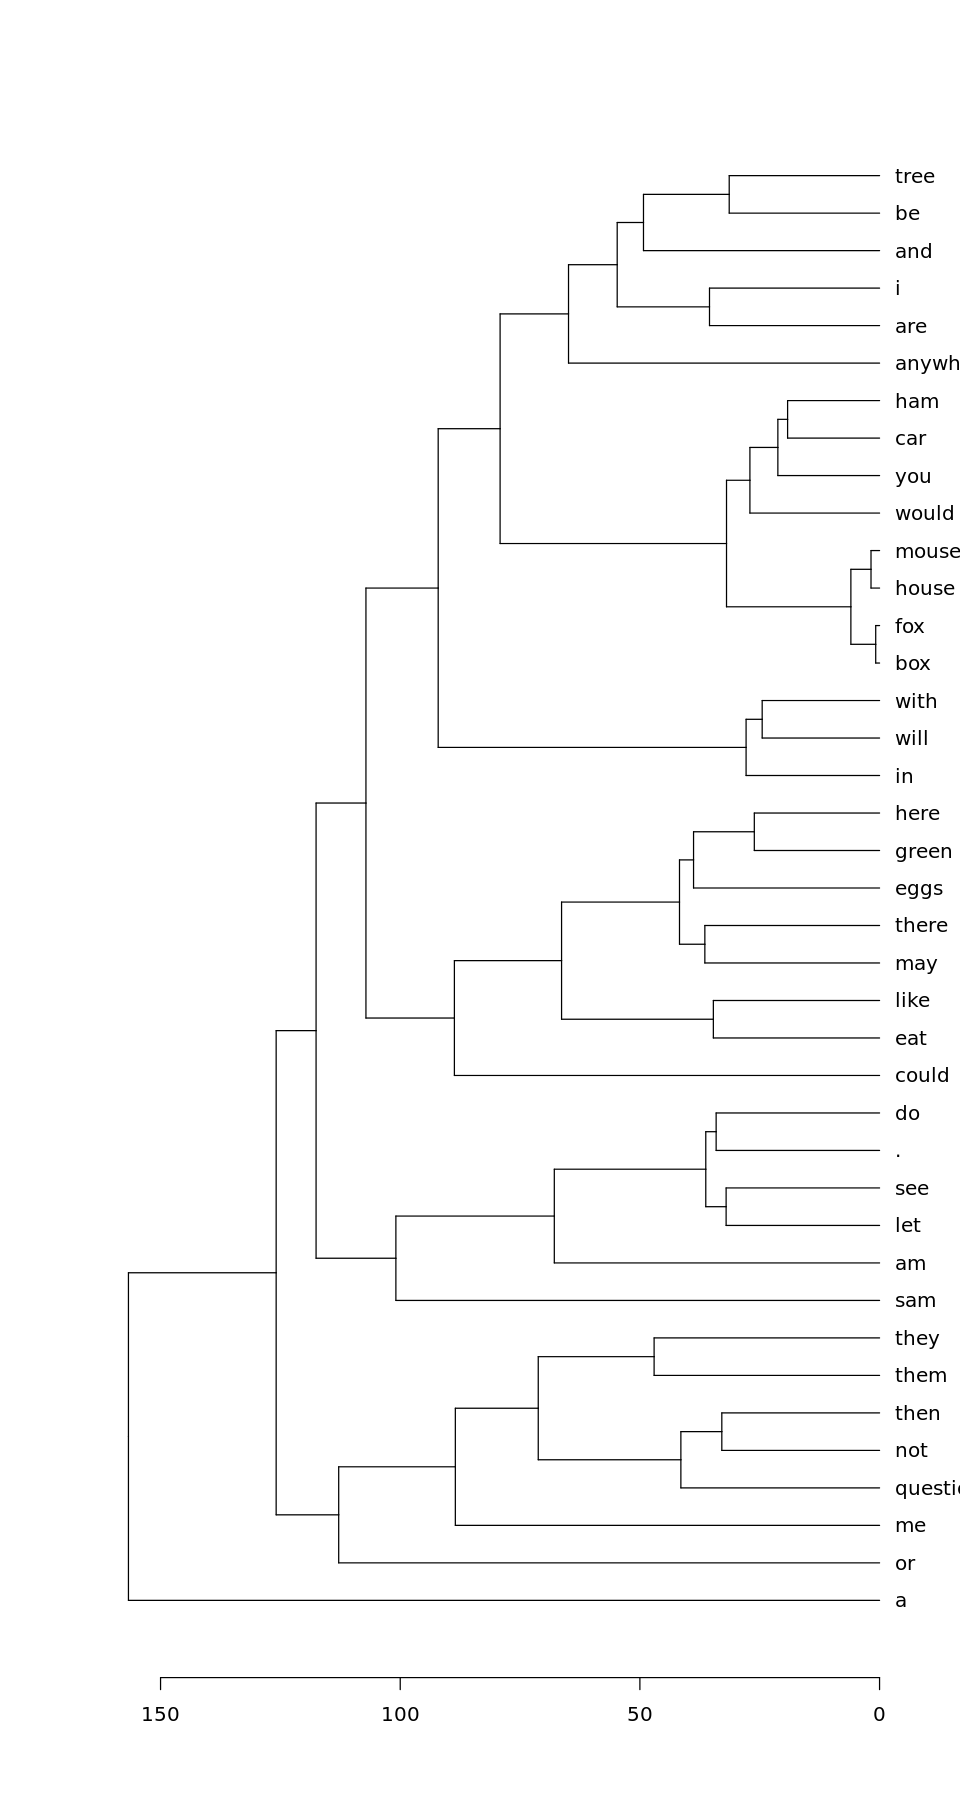

In [6]:
ws = data.frame(t(nn$weights[[1]][[2]][2:(NumHidden+1), 1:V]))
rownames(ws) = vocab
options(repr.plot.width=8, repr.plot.height=15)
dist_mat <- dist(ws, method = 'euclidean')
hclust_avg <- hclust(dist_mat, method = 'average')
plot(as.dendrogram(hclust_avg), horiz=TRUE)

### Skipgram Model

Now we will do the same for the skipgram version of the model.

In [7]:
strformula = paste(contextvars, "~", targetvars)
NumHidden = 5
set.seed(9)
nnSkipgram = neuralnet(as.formula(strformula), data=df, hidden=NumHidden, act.fct="logistic", linear.output=FALSE)
print ("Error:")
print(nnSkipgram$result.matrix[[1]])
print("Number of steps:")
print(nnSkipgram$result.matrix[[3]])

[1] "Error:"
[1] 147.6176
[1] "Number of steps:"
[1] 1576


And now we can plot the hierachical cluster diagram for the skipgram version of the model. 

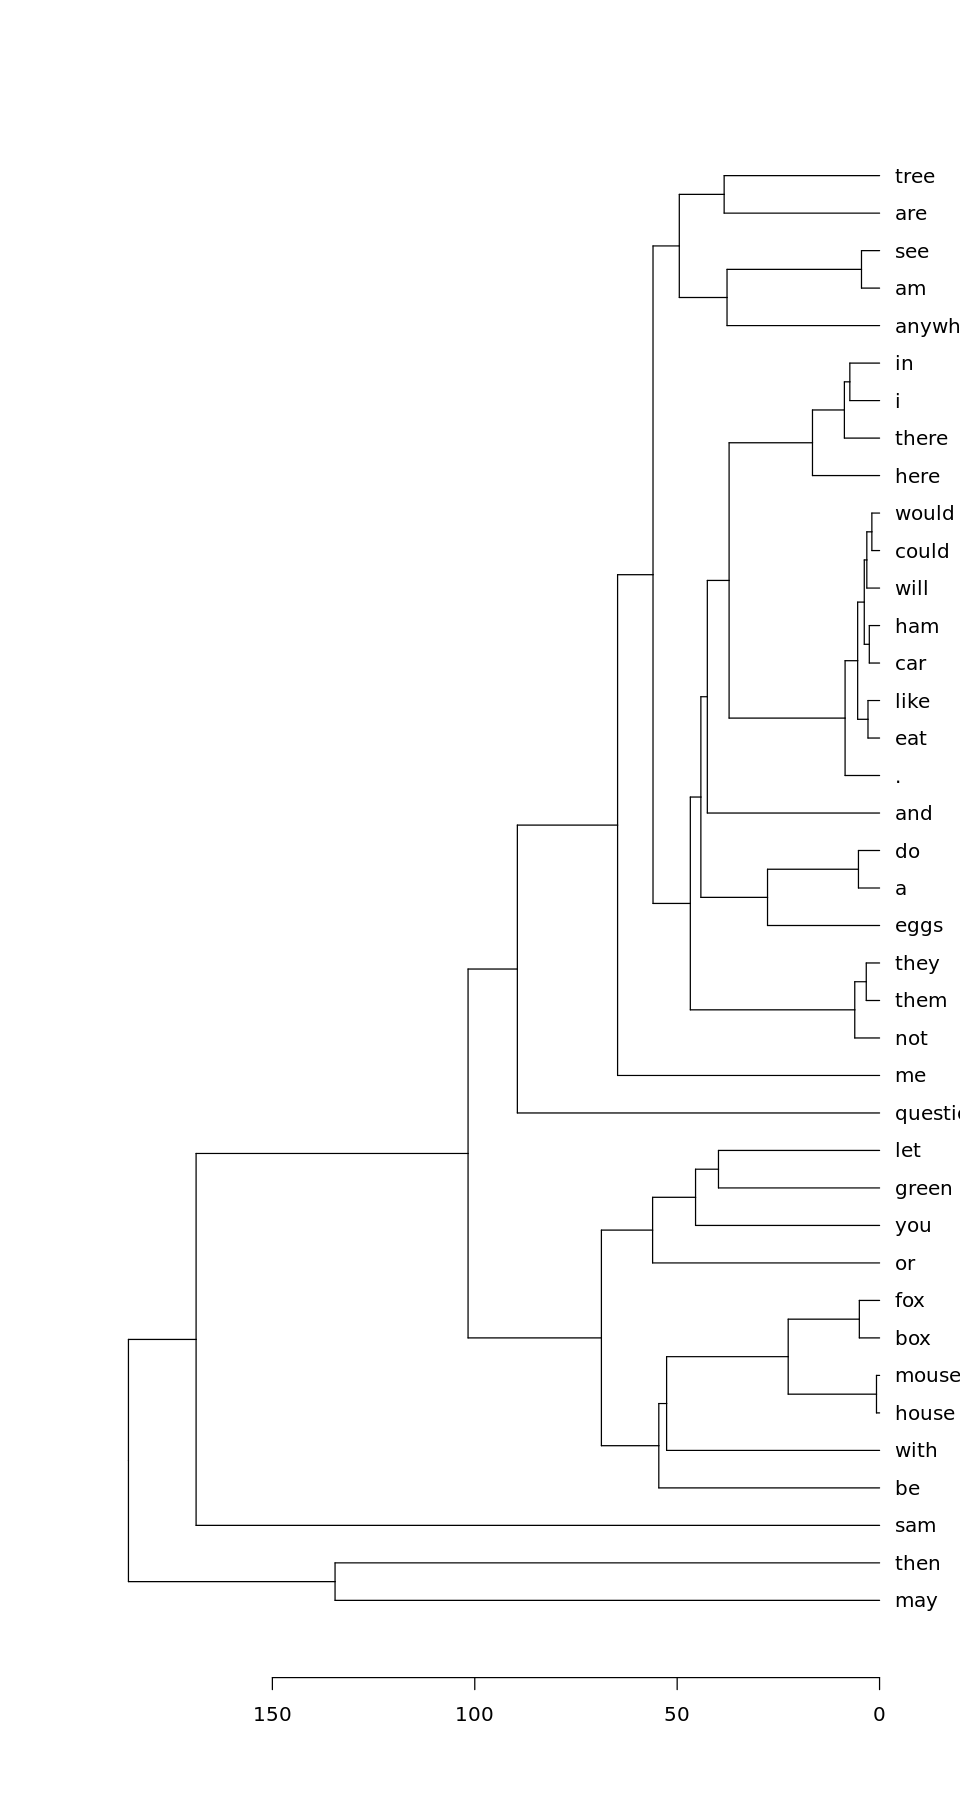

In [8]:
ws = data.frame(nnSkipgram$weights[[1]][[1]][2:(V+1),1:NumHidden])
rownames(ws) = vocab
options(repr.plot.width=8, repr.plot.height=15)
dist_mat <- dist(ws, method = 'euclidean')
hclust_avg <- hclust(dist_mat, method = 'average')
plot(as.dendrogram(hclust_avg), horiz=TRUE)


### Exercise 1

A major part of the work in applying neural networks to a problem is to decide on the parameters one will use. We will focus on two main ones for this assignment - the context size and the number of hidden units. 

The context size determines how many words to the left and right of the target word the models considers. The number of hidden units determines how many units are in the middle layer that maps the inputs to the outputs.  Changing these parameters impacts on the performance of the network.

Using the code above, run the CBoW and Skipgram models with different values of the context size and different numbers hidden units. Specifically, consider context sizes of 1 or 2 and 5, 10 or 15 hidden units. Tabulate the error and the number of steps taken to converge. 

=== BEGIN MARK SCHEME ===


| Model | Context Size | Number of Hidden Units | Error | Number of Steps |
| --- | --- | --- | --- | --- |
|CBoW|1|5|30.600|962|
|CBoW|1|10| 31.85|163|
|CBoW|1|15|29.58|143|
|CBoW|2|5|21.45|2823|
|CBoW|2|10|19.24|200|
|CBoW|2|15|15.05|135|
|Skipgram|1|5|147.62|1576|
|Skipgram|1|10|141.76|343|
|Skipgram|1|15|138.72|326|
|Skipgram|2|5|313.01|38904|
|Skipgram|2|10|293.09|3196|
|Skipgram|2|15|289.77|843|

=== END MARK SCHEME ===

### Exercise 2

Why are the CBoW error values different from the Skipgram values?

=== BEGIN MARK SCHEME ===

The CBoW error values will be lower than the Skipgram values, because the CBoW model is trying to predict patterns in which only one unit is active, whereas the skipgram model is trying to predict patterns in which multiple units are active (2 if context size is 1 and 4 if the context size is 2).

=== END MARK SCHEME ===

### Exercise 3

How do the error values change as a function of the context size? Why?

=== BEGIN MARK SCHEME ===

The CBoW model is always trying to predict one word, regardless of the context size. Having a context size of 2 provides more information on which the model can make its decision and so the error values tend to be lower.

For the skipgram model, the context size changes the number of words that the model has to predict. Like in the last question predicting more words is harder than predict fewer words, and so for the skip gram model that error values are lower when the context size is 1.

=== END MARK SCHEME ===

### Exercise 4

How do the error values typically change as a function of the number hidden units? Why would that be the case?

=== BEGIN MARK SCHEME ===

Typically, the error values will decrease (although not always). This pattern occurs because there are more parmeters in the model (like degrees of freedom in classical statistical models) and so it is easier for the algorithm to find a set of weights that mimic the training set.

=== END MARK SCHEME ===

### Exercise 5

In general, the more hidden units you have the lower the error becomes. Does that mean that more hidden units are always better? 

Compare the hierarachical cluster digram of the CBoW model with a context size of 1 and 10 hidden units and with 100 hidden units. Pay particular attention to where "tree" is placed relative to the other nouns like "box" and "house".  Which makes the most sense? When will fewer hidden units be better?

=== BEGIN MARK SCHEME ===

In the 10 hidden unit solution is near "fox", "house" etc whereas in the 100 hidden unit solution it is not. As "tree" is a noun that fills a similar kind of role as words like "fox" and "house" in the text, we would like it to appear near these words. 

In the 100 unit solution there are more hidden units than there are vocabulary items (39). The network can assign each word to a different hidden unit - that is they can each be placed in an independent part of the space and they do not need to interact. With only 10 hidden units, however, the algorithm has to assign positions to the different words that minimize the error even though it can't put them in very different places. The way to do that is to put words that have similar contexts in similar places. 

From a cognitive modelling perspective this is a good thing as it explains the kinds of generalizations we see people make. 

More generally, there is a sweet spot in terms of the number of hidden units. Too many and everything is assigned a unique location and generalization is poor. Too few and the network may not have the ability to distinguish words that have very dissimilar meanings.

=== END MARK SCHEME ===